In [1]:
# NOTE
# 加入促銷日期
# 遊戲付費指標 ARPU / ARPPU
# 加入固定報表呈現
# 加入可以單獨輸入某運分的資料而不是整批資料輸入

## 將 Mycard 平台所輸出的檔案轉成分析用的檔案

## 使用的資料表
# 1. df1 - suc_records: 每筆交易紀錄
# 2. df2 - user: 以 user id 為基準, 看 RFM 相關紀錄
# 3. df3 - Daily_per: 以日期為基準, 看每日活躍 和巴哈熱度

##其他
# 1. df_ - 原始 mycard 交易紀錄

In [2]:
# 使用套件
import pandas as pd
import numpy as np
import datetime as dt
import sklearn
import glob
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

C:\Users\Ting\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


STEP1: ETL 過程

In [3]:
#### DF1: 
# 1.讀 Mycard 交易紀錄資料

# 透過給定地址和模糊比對,把全部符合規則的交易紀錄檔案讀入至 allFiles
path =r"C:\Users\Ting\Desktop\mycard_paypal金流營收\MyCard_record" # use your path
allFiles = glob.glob(path + "/*.xlsx")
print(len(allFiles))
allFiles

52


['C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201701-MyCard_ATM.xlsx',
 'C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201701-MyCard_member.xlsx',
 'C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201701-MyCard_Retailer.xlsx',
 'C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201702-MyCard_ATM.xlsx',
 'C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201702-MyCard_member.xlsx',
 'C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201702-MyCard_Retailer.xlsx',
 'C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201703-MyCard_ATM.xlsx',
 'C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201703-MyCard_member.xlsx',
 'C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201703-MyCard_Retailer.xlsx',
 'C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201704-MyCard_ATM.xlsx',
 'C:\\Users\\Ting\\Desktop\\mycard_paypal金流營收\\MyCard_record\\201704-MyCard_member.xlsx',
 'C:\\Users\\Tin

In [4]:
# 先創造一個 dic 來紀錄要存的資料欄位 來改變樹入欄位的名稱
columns_name = {"交易日期 Transaction Date of Success":"Date_of_Success", 
                "交易成功時間 Success Time of Transaction":"Date_of_Success",
                "交易成功時間 Transaction Date of Success":"Date_of_Success",
                "金額 Unit Price":"Price","定價 List Price":"Price",
                "取消狀態 Canceled or not":"Canceled_or_not",
                "取消與否 Cancel or NO":"Canceled_or_not",
                "取消與否 Cancel or No":"Canceled_or_not",
                "使用者ID User ID":"User_ID",
                "會員/遊戲帳號 User Account/Game Account":"User_ID",
                "通路別 Distributor Type":"Channel","付費方式 Payment":"Channel"}

# 先透過表格名稱來判斷該檔案屬於哪個儲值管道
temp = pd.DataFrame()
temp2 = pd.DataFrame()
list_ = []

for file_ in allFiles:
    # 用檔案名稱來判斷屬於哪個儲值管道
    if "MyCard_ATM" in file_:
        # 重新命名欄位名稱
        temp = pd.read_excel(file_ ,skiprow=0).rename(columns=columns_name)
        # 只要特定幾個欄位
        temp2 = temp[["Date_of_Success","Price","Canceled_or_not","Channel","User_ID"]]
        # 把該 df 新加到 list 中
        list_.append(temp2)
    
    if "MyCard_Retailer" in file_:
        temp = pd.read_excel(file_,skiprow=0).rename(columns=columns_name)
        temp2 = temp[["Date_of_Success","Price","Canceled_or_not","Channel","User_ID"]]
        list_.append(temp2)
    
    if "MyCard_member" in file_:
        temp = pd.read_excel(file_,skiprow=0)
        temp['User_ID'] = 0
        temp["Channel"] = "Mycard_Member"
        temp = temp.rename(columns=columns_name)
        temp2 = temp[["Date_of_Success","Price","Canceled_or_not","Channel","User_ID"]]
        list_.append(temp2)
        
# 把存多個df的 list 資料轉 dataframe
df_ = pd.concat(list_)
df_.head()

,Date_of_Success,Price,Canceled_or_not,Channel,User_ID
0,2017/1/1 上午 12:04:32,1500.0,否,中華電信839,83430
1,2017/1/1 上午 12:04:50,2499.0,否,遠傳電信帳單付費,127809
2,2017/1/1 上午 12:09:03,999.0,否,台灣之星,112241
3,2017/1/1 上午 12:26:07,2499.0,否,遠傳電信帳單付費,124953
4,2017/1/1 上午 12:26:22,2499.0,否,遠傳電信帳單付費,5659


In [5]:
# 調整原始df 的資料型態
# 把原本的 df_ 保留住
records = df_.copy()

# 將 User_ID 轉成 文字
records["User_ID"] = records["User_ID"].apply(str)

# 調整 Canceled_or_not 的欄位值
# 確認是前狀況
print(records["Canceled_or_not"].value_counts())

def canceled(str_):
    if str_ == "未取消" or str_ =="否" or str_ =="NO":
        return "No"
    else:
        return "Yes"
    
records["Canceled_or_not"] = records["Canceled_or_not"].apply(canceled)

# 確認調整狀況
records["Canceled_or_not"].value_counts()

未取消        473295
否          449898
NO         367703
是             137
已取消還原點數       108
Cancel         13
Name: Canceled_or_not, dtype: int64


No     1290896
Yes        258
Name: Canceled_or_not, dtype: int64

In [6]:
## 調整欄位的時間格式
# 新增交易日 Date, 透過切資料找第一個值
records["Date"] = pd.to_datetime(records["Date_of_Success"].str.split(" ").str[0])

# 看資料共包含幾天
print(len(records["Date"].unique()))

## 確認時間格式的種類 (用空格來分辨
list3_ = []
for x in records["Date_of_Success"].tolist():
    list3_.append(len(x.split(" ")))

# set 找不重複的資料, 發現有兩種形式的資料
print("時間型態格式")
print(set(list3_))

# 把文字的交易時間轉成 時間格式
def time_type(x):
    if len(x.split(" ")) == 3:
        x = x.replace(" 上午 ",":AM:").replace(" 下午 ",":PM:")
        return dt.datetime.strptime(x,"%Y/%m/%d:%p:%I:%M:%S")
    if len(x.split(" ")) == 2:
        return dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S")

records["Date_Time"] = records["Date_of_Success"].apply(lambda x: time_type(x))
print("看資料的時間週期")
records["Date_Time"].describe()

# 新增加 小時 & weekday & month 資料
def tohour_(x):
    return x.strftime("%H")

def toweekday_(x):
    return x.strftime("%a")

def tomonth_(x):
    return x.strftime("%m")

records["hour"] = records["Date_Time"].apply(tohour_)
records["weekday"] = records["Date_Time"].apply(toweekday_)
records["month"] = records["Date_Time"].apply(tomonth_)

455
時間型態格式
{2, 3}
看資料的時間週期


In [7]:
## 新加欄位 - 買虛寶所對應到的商品

# 透過每次儲值金額表示玩家購買之產品
#大品項
Package_list = [149,299,499,999,1249,2499]
PackageUpgrade_list = [350, 700, 750, 1100, 1500, 2200]
Pearl_list = [150, 300, 500, 1000, 2000, 3000, 5000, 10000]

# 購買細項 (產包升級或是購買產包
Starter_P_list = [149, 299]
Essential_P_list = [499, 999]
Luxurious_P_list = [1249, 2499]
StoE_P_list = [350,700]
StoL_P_list = [1100, 2200]
EtoL_P_list = [750, 1500]


# 將值替換成購買品項
def Purchase_item(price):
    if price in Package_list:
        return "Purchase_Package"
    if price in PackageUpgrade_list:
        return "Upgrade_Package"
    if price in Pearl_list:
        return "Purchase_Pearl"
    
def Purchase_detail(price):
    if price in Starter_P_list:
        return "Starter_P"
    if price in Essential_P_list:
        return "Essential_P"
    if price in Luxurious_P_list:
        return "Luxurious_P"
    if price in StoE_P_list:
        return "StoE_P"
    if price in StoL_P_list:
        return "StoL_P"
    if price in EtoL_P_list:
        return "EtoL_P"
    if price in Pearl_list:
        return "Purchase_Pearl"
    
records["Purchase_item"] = records["Price"].apply(Purchase_item)
print(records["Purchase_item"].value_counts())

records["Purchase_detail"] = records["Price"].apply(Purchase_detail)
records["Purchase_detail"].value_counts()

Purchase_Pearl      1006927
Purchase_Package     232915
Upgrade_Package       51311
Name: Purchase_item, dtype: int64


Purchase_Pearl    1006927
Starter_P          164279
Luxurious_P         34929
Essential_P         33707
StoL_P              26086
EtoL_P              15944
StoE_P               9281
Name: Purchase_detail, dtype: int64

In [8]:
## 把儲值通路分類
ATM_list = ["銀行轉帳", "中華郵政WebATM",  "玉山銀行WebATM", "國泰世華MyATM",
            "中國信託WebATM", "台灣銀行WebATM",  "合作金庫WebATM",
            "新光銀行WebATM", "土地銀行WebATM","華南銀行WebATM", "第一銀行WebATM", 
            "兆豐銀行WebATM", "台新銀行WebATM",  "彰化銀行WebATM", "台北富邦WebATM", 
            "上海銀行WebATM","日盛銀行WebATM"]

Convience_Stores_list = ["全家以外之超商通路", "全家超商通路"]
Credit_Card_list = ["信用卡-台灣地區(3D驗證)"]
Micropayment_list = ["台灣大哥大電信", "中華電信839", "中華電信HiNet","遠傳電信帳單付費",
                     "中華電信市內電話輕鬆付","亞太電信","台灣之星","Seednet"]

Mycard_Member_list = ["Mycard_Member"]
General_Retailer_list = ["一般通路"]

def Payment_Type(pay):
    if pay in ATM_list:
        return "ATM"
    if pay in Convience_Stores_list:
        return "Convience_Stores"
    if pay in Credit_Card_list:
        return "Credit_Card"
    if pay in Micropayment_list:
        return "Micropayment"
    if pay in Mycard_Member_list:
        return "Mycard_Member"
    if pay in General_Retailer_list:
        return "General_Retailer"

records["Payment_type"] = records["Channel"].apply(Payment_Type)

print(records["Payment_type"].value_counts())
print(records["Channel"].value_counts())

Mycard_Member       473403
Convience_Stores    282649
Credit_Card         226229
Micropayment        187378
General_Retailer     85067
ATM                  35025
Name: Payment_type, dtype: int64
Mycard_Member      473403
信用卡-台灣地區(3D驗證)     226229
全家以外之超商通路          191222
全家超商通路              91427
一般通路                85067
遠傳電信帳單付費            67349
台灣大哥大電信             57254
中華電信839             39176
玉山銀行WebATM           9715
亞太電信                 7183
中華電信市內電話輕鬆付          6540
銀行轉帳                 5924
中華電信HiNet            5613
中華郵政WebATM           5531
台灣之星                 4121
中國信託WebATM           3196
台灣銀行WebATM           1652
第一銀行WebATM           1591
合作金庫WebATM           1433
台灣地區信用卡付款(3D驗證)      1403
國泰世華MyATM            1356
華南銀行WebATM           1282
兆豐銀行WebATM           1278
台新銀行WebATM            641
台北富邦WebATM            561
土地銀行WebATM            299
彰化銀行WebATM            233
新光銀行WebATM            186
Seednet               142
上海銀行WebATM            129
日盛銀行WebATM             18

In [9]:
##　把取消的交易拿掉
suc_records = records[records["Canceled_or_not"] =="No"]

# 確認是否有完整篩選
print(suc_records["Canceled_or_not"].value_counts())
suc_records.head()

No    1290896
Name: Canceled_or_not, dtype: int64


,Date_of_Success,Price,Canceled_or_not,Channel,User_ID,Date,Date_Time,hour,weekday,month,Purchase_item,Purchase_detail,Payment_type
0,2017/1/1 上午 12:04:32,1500.0,No,中華電信839,83430,2017-01-01,2017-01-01 00:04:32,00,Sun,01,Upgrade_Package,EtoL_P,Micropayment
1,2017/1/1 上午 12:04:50,2499.0,No,遠傳電信帳單付費,127809,2017-01-01,2017-01-01 00:04:50,00,Sun,01,Purchase_Package,Luxurious_P,Micropayment
2,2017/1/1 上午 12:09:03,999.0,No,台灣之星,112241,2017-01-01,2017-01-01 00:09:03,00,Sun,01,Purchase_Package,Essential_P,Micropayment
3,2017/1/1 上午 12:26:07,2499.0,No,遠傳電信帳單付費,124953,2017-01-01,2017-01-01 00:26:07,00,Sun,01,Purchase_Package,Luxurious_P,Micropayment
4,2017/1/1 上午 12:26:22,2499.0,No,遠傳電信帳單付費,5659,2017-01-01,2017-01-01 00:26:22,00,Sun,01,Purchase_Package,Luxurious_P,Micropayment


In [11]:
##### 創造 DF2
## 以 USER id 為依據的表單
## RFM 分析

# 已將 user 轉成 string 所以0 要用 ""
# 因為無法用 id 判斷 Mycard 會員，所以要將資料拿掉
user_temp = suc_records[suc_records["User_ID"] != "0"]

# 累計付款總額
Total_Amount = user_temp.groupby("User_ID").Price.sum()

# 累計付款次數
Total_Times = user_temp.groupby("User_ID").Price.count()

# 找出玩家上一次付款的時間
Previous_Date = user_temp.groupby("User_ID")["Date"].max()

# 找出玩家第一次付款的時間, 用第一次買的紀錄來判斷 (可能是產包或是珍珠)
First_Date = user_temp.groupby("User_ID")["Date"].min()

# 找出玩家在不同支付管道的購買次數 ATM , Convience_Stores , Credit_Card, Micropayment, General_Retailer
temp = user_temp.pivot_table(values="Price" , index="User_ID", columns="Payment_type", aggfunc="count")

#　再將付款紀錄和　user id 結合成新的 df
list_of_series = [Total_Amount, Total_Times, Previous_Date, First_Date]
temp_ = pd.concat(list_of_series,axis=1)
user = pd.concat([temp,temp_],axis=1).fillna(0)

# 重新命名欄位名稱
cols = [ "ATM_count", "CS_count", "Credit_count", "Retailer_count", "Micro_count",
        "Total_amount",'Total_count', "Previous_date" , "First_date"]
user.columns =cols

# 新增欄位, 已多久沒付款
user["Stopping_days"] = (dt.datetime(2018,3,31) - user["Previous_date"])/dt.timedelta(days=1)

# 新增欄位 已加入遊戲多久
user["Playing_days"] = (dt.datetime(2018,3,31) - user["First_date"])/dt.timedelta(days=1)

# 新增欄位 加入遊戲至上次附款日期時間
user["Paying_days"] = (user["Previous_date"] - user["First_date"])/dt.timedelta(days=1)

# 確認玩家購買產包型態
Pack_df = user_temp[user_temp["Purchase_item"] =="Purchase_Package"].copy()
Pack_df.columns = ["Pack_type" if x=="Purchase_detail" else x for x in Pack_df.columns]


# 讓玩家按總付款金額排序
user = user.sort_values(by="Total_amount", ascending= False).reset_index()

# 將 index 欄位命名成 User_ID
user.columns = ["User_ID" if x=="index" else x for x in user.columns]

user = pd.merge(user,Pack_df[["User_ID","Pack_type"]],on="User_ID",how="left").fillna("NA")

# 新增玩家傾向附款管道 (>0.6 算篇好, 用次數算 而不是總消費金額
def Pay_type(df):
    if (df["ATM_count"]/df["Total_count"]) >0.6:
        return "ATM"
    elif (df["CS_count"]/df["Total_count"]) >0.6:
        return "CS"
    elif (df["Credit_count"]/df["Total_count"]) >0.6:
        return "Credit_card"
    elif (df["Retailer_count"]/df["Total_count"]) >0.6:
        return "retailer"
    elif (df["Micro_count"]/df["Total_count"]) >0.6:
        return "Micro"
    else:
        return "multi_payments"
        
user["Prefer_payment"] = user.apply(Pay_type,axis=1)

# 新增購買珍珠次數
def pearl_count(df):
    if df["Pack_type"] == "NA":
        return df["Total_count"]
    else:
        return df["Total_count"] - 1
    
user["Pearl_count"] = user.apply(pearl_count, axis=1)

# 新增購買玩家屬性 (有無購買珍珠)
def paid_user(x):
    if x>0:
        return "Paid_user"
    else:
        return "NonPaid_user"
    
user["User_type"] = user["Pearl_count"].apply(paid_user)

user.head()

,User_ID,ATM_count,CS_count,Credit_count,Retailer_count,Micro_count,Total_amount,Total_count,Previous_date,First_date,Stopping_days,Playing_days,Paying_days,Pack_type,Prefer_payment,Pearl_count,User_type
0,107318,0.0,451.0,0.0,54.0,0.0,2297000.0,505,2017-11-29,2017-01-15,122.0,440.0,318.0,NA,CS,505,Paid_user
1,14535,4.0,26.0,337.0,2.0,0.0,1809000.0,370,2018-03-29,2017-01-11,2.0,444.0,442.0,NA,Credit_card,370,Paid_user
2,85390,0.0,52.0,0.0,255.0,0.0,1504500.0,307,2018-01-31,2017-01-13,59.0,442.0,383.0,NA,retailer,307,Paid_user
3,2005,0.0,6.0,0.0,278.0,0.0,1239000.0,284,2017-11-09,2017-01-20,142.0,435.0,293.0,NA,retailer,284,Paid_user
4,113455,131.0,0.0,2.0,0.0,0.0,1231650.0,133,2018-03-23,2017-06-25,8.0,279.0,271.0,NA,ATM,133,Paid_user


In [12]:
##### 創造 DF3
## 以每日為基準看遊戲和巴哈資料

# 匯入使用者人數 active user
path =r"C:\Users\Ting\Desktop\input_source\active_user.csv"
active_user = pd.read_csv(path,sep=",")
active_user.Date = pd.to_datetime(active_user.Date)

# 把每日的營收整理
daily_revenue = suc_records.groupby("Date").Price.sum().reset_index()
daily_paid_user = suc_records.groupby(pd.Grouper(freq="d",key="Date")).User_ID.count().reset_index()
daily_paid_user.columns = ["Date", "Paid_user"]

# 合併兩個資料
temp = pd.merge(active_user, daily_revenue,how="left",on="Date")
Daily_per = pd.merge(temp, daily_paid_user, how="left", on= "Date")

Daily_per["NRU%"] = Daily_per["NRU_PKG"] / Daily_per["DAU_PKG"]
Daily_per["Paid%"] = Daily_per["Paid_user"] / Daily_per["DAU_PKG"]
Daily_per

,Date,NRU_PKG,NRU_Guest,NRU_All,Register,DAU_PKG,Baha_imp,Price,Paid_user,NRU%,Paid%
0,2017-01-11,21265,NaN,21266,10371.0,21303,1307096,8758813.0,5299,0.998216,0.248744
1,2017-01-12,3448,NaN,3448,7705.0,23860,1129074,5452305.0,3626,0.144510,0.151970
2,2017-01-13,1945,NaN,1945,5438.0,24479,937846,4925078.0,3279,0.079456,0.133952
3,2017-01-14,1654,NaN,1654,6268.0,25440,907397,5459841.0,3729,0.065016,0.146580
4,2017-01-15,1405,NaN,1405,6051.0,26279,940037,5059288.0,3690,0.053465,0.140416
5,2017-01-16,932,NaN,932,4703.0,26058,968555,4134930.0,3201,0.035766,0.122841
6,2017-01-17,737,NaN,737,4789.0,25960,952040,4647871.0,3882,0.028390,0.149538
7,2017-01-18,10993,NaN,10993,6040.0,36364,1218090,7349839.0,6516,0.302304,0.179188
8,2017-01-19,4281,NaN,4281,5254.0,39417,1034615,5223078.0,4770,0.108608,0.121014
9,2017-01-20,2505,NaN,2505,5961.0,40034,1032869,4607739.0,4382,0.062572,0.109457


In [32]:
# 把有付錢買過一次珍珠的用戶拉出
paid_user = user[user["User_type"]== "Paid_user"].copy()

STEP2: 資料視覺化

PAT1: 整體圖表

       Payment_type        Price  Revenue%     Revenue
0               ATM   65721835.0  0.048275   65.721835
1  Convience_Stores  255193164.0  0.187450  255.193164
2       Credit_Card  298861437.0  0.219526  298.861437
3  General_Retailer  118748536.0  0.087226  118.748536
4      Micropayment  180381547.0  0.132498  180.381547
5     Mycard_Member  442488582.0  0.325026  442.488582


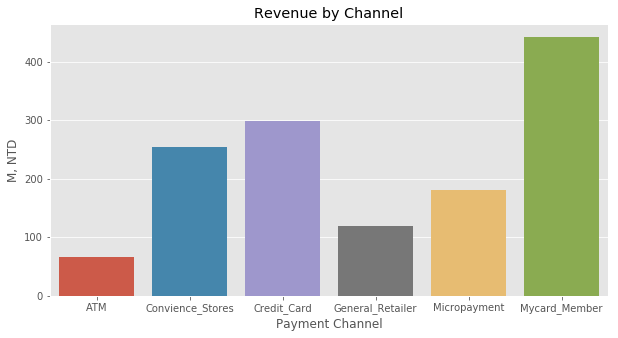

In [13]:
# 確認不同管道的營收狀況
src = suc_records.groupby("Payment_type").Price.sum().reset_index()
src["Revenue%"] = src["Price"]/src["Price"].sum()
src["Revenue"] = src["Price"]/1000000
print(src)

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.title('Revenue by Channel')
sns.barplot(x="Payment_type", y="Revenue", data = src).set(xlabel="Payment Channel" , ylabel="M, NTD")

plt.savefig('Revenue_by_channel.png', bbox_inches='tight')

     Price  User_ID
0    150.0    96528
1    300.0   262268
2    500.0   154498
3   1000.0   257661
4   2000.0    53292
5   3000.0   160641
6   5000.0    20264
7  10000.0     1704


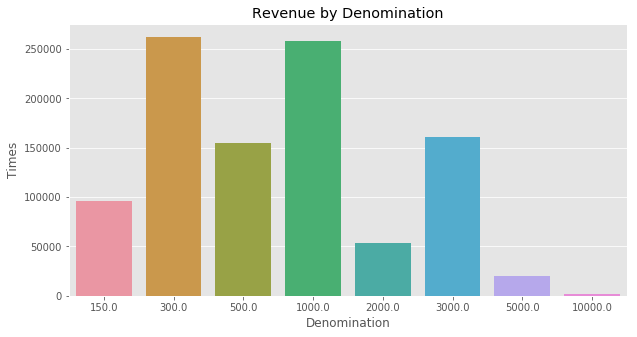

In [14]:
# 買珍珠的面額概況
temp = suc_records[suc_records["Purchase_item"] =="Purchase_Pearl"]
src = temp.groupby("Price").User_ID.count().fillna(0).reset_index()
print(src)

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.title('Revenue by Denomination')
sns.barplot(x="Price", y="User_ID", data = src).set(xlabel="Denomination" , ylabel="Times")

plt.savefig('Revenue_by_Denomination.png', bbox_inches='tight')

  Purchase_detail   Price
0     Essential_P   33693
2     Luxurious_P   34893
4       Starter_P  164201


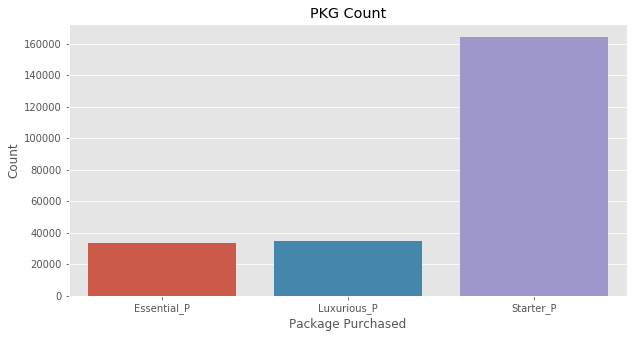

In [48]:
# 確認產包購買狀況分布, 
# 要先指定三個產包條件 (isin)
src = suc_records.groupby("Purchase_detail").Price.count().reset_index()
src2 = src[src.Purchase_detail.isin(["Essential_P", "Luxurious_P","Starter_P"])]
print(src2)
plt.figure(figsize=(10,5))

plt.title('PKG Count')
sns.barplot(x="Purchase_detail", y="Price", data = src2).set(xlabel="Package Purchased" , ylabel="Count")

plt.savefig('PKG_count.png', bbox_inches='tight')

PART2: MONTHLY STATS

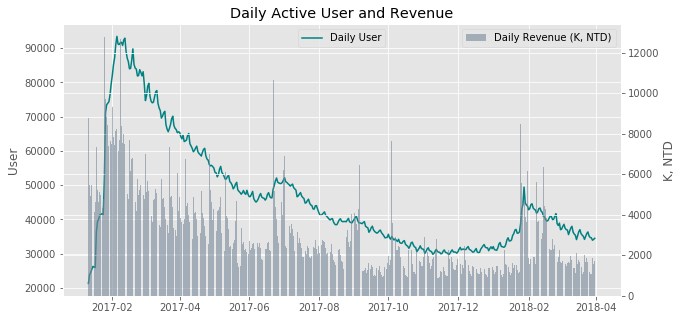

In [15]:
# 畫每日玩家和營收狀態
plt.figure(figsize=(10,5))
plt.style.use("ggplot")
plt.title("Daily Active User and Revenue")

a = plt.plot(Daily_per["Date"], Daily_per["DAU_PKG"], label="Daily User", color="teal")
plt.ylabel("User")
plt.legend(loc=9)


plt.twinx()
b = plt.bar(Daily_per["Date"], Daily_per["Price"]/1000, label="Daily Revenue (K, NTD)", 
             color="lightslategray", alpha =0.6)


plt.ylabel("K, NTD")
plt.xlabel("Date")
plt.legend(loc=1)

plt.savefig('DailyUser&Revenue.png', bbox_inches='tight')

,NRU_PKG,NRU_Guest,NRU_All,Register,DAU_PKG,Baha_imp,Price,Paid_user,NRU%,Paid%
NRU_PKG,1.000000,0.795077,0.992611,0.833905,0.298238,0.459837,0.601380,0.655515,0.859193,0.653734
NRU_Guest,0.795077,1.000000,0.853176,0.832745,0.421867,0.443214,0.569530,0.685946,0.779276,0.593100
NRU_All,0.992611,0.853176,1.000000,0.853839,0.335905,0.479537,0.621773,0.690192,0.815411,0.656093
Register,0.833905,0.832745,0.853839,1.000000,0.469751,0.618053,0.738592,0.821577,0.572459,0.730435
DAU_PKG,0.298238,0.421867,0.335905,0.469751,1.000000,0.867204,0.694692,0.700877,0.044205,0.205336
Baha_imp,0.459837,0.443214,0.479537,0.618053,0.867204,1.000000,0.806936,0.792223,0.246808,0.458951
Price,0.601380,0.569530,0.621773,0.738592,0.694692,0.806936,1.000000,0.965822,0.388438,0.811224
Paid_user,0.655515,0.685946,0.690192,0.821577,0.700877,0.792223,0.965822,1.000000,0.361332,0.803556
NRU%,0.859193,0.779276,0.815411,0.572459,0.044205,0.246808,0.388438,0.361332,1.000000,0.555851
Paid%,0.653734,0.593100,0.656093,0.730435,0.205336,0.458951,0.811224,0.803556,0.555851,1.000000


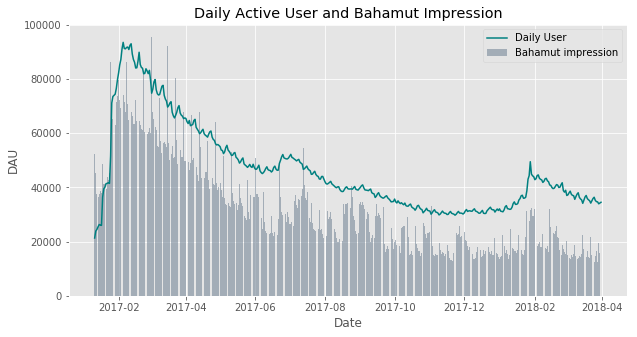

In [45]:
# 畫DAU 和每日付費玩家數目
plt.figure(figsize=(10,5))
plt.style.use("ggplot")
plt.title("Daily Active User and Bahamut Impression")

a = plt.plot(Daily_per["Date"], Daily_per["DAU_PKG"], label="Daily User", color="teal")
b = plt.bar(Daily_per["Date"], Daily_per["Baha_imp"]/25, label="Bahamut impression", 
             color="lightslategray", alpha =0.6)

plt.ylabel("DAU")
plt.xlabel("Date")
plt.legend()

plt.savefig('DailyUser&Baha.png', bbox_inches='tight')

# 確認欄位間的相關係數
Daily_per.corr()

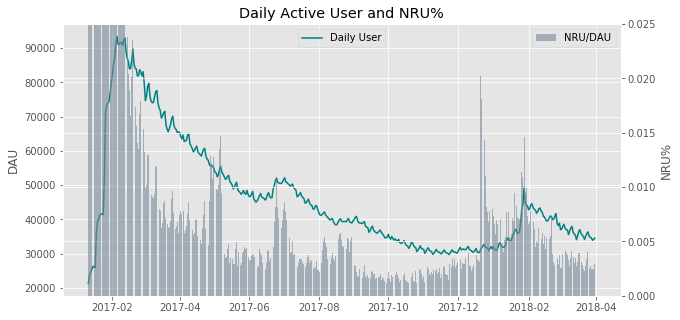

In [44]:
# 畫DAU 和每日新增加玩家 (DAU & NRU
plt.figure(figsize=(10,5))
plt.style.use("ggplot")
plt.title("Daily Active User and NRU%")

a = plt.plot(Daily_per["Date"], Daily_per["DAU_PKG"], label="Daily User", color="teal")
plt.ylabel("DAU")
plt.legend(loc=9)


plt.twinx()
b = plt.bar(Daily_per["Date"], Daily_per["NRU%"], label="NRU/DAU", 
             color="lightslategray", alpha =0.6)

plt.ylim(0,0.025)
plt.ylabel("NRU%")
plt.xlabel("Date")
plt.legend(loc=1)

plt.savefig('DailyUser&NRU%.png', bbox_inches='tight')

        Month  Monthly_user  Monthly_revenue  Monthly_ARPPU
0  2017-01-31        150585      154742817.0        1027.61
1  2017-02-28        190796      188093198.0         985.83
2  2017-03-31        130524      142073624.0        1088.49
3  2017-04-30        110081      120037904.0        1090.45
4  2017-05-31         91823       95732097.0        1042.57
5  2017-06-30         85225       90385619.0        1060.55
6  2017-07-31         78952       85862655.0        1087.53
7  2017-08-31         70602       75646139.0        1071.44
8  2017-09-30         57503       58627036.0        1019.55
9  2017-10-31         53553       62355198.0        1164.36
10 2017-11-30         46937       47959699.0        1021.79
11 2017-12-31         41263       42586033.0        1032.06
12 2018-01-31         62943       69020826.0        1096.56
13 2018-02-28         73077       81267751.0        1112.08
14 2018-03-31         47032       48808867.0        1037.78


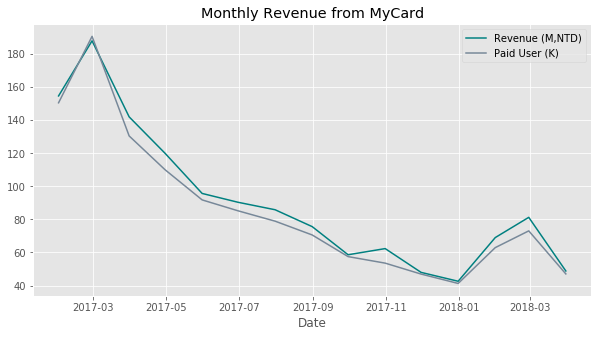

In [16]:
# 付費玩家的人數變化
src = suc_records.groupby(pd.Grouper(freq='m',key="Date_Time")).agg({"User_ID":"count","Price":"sum"}).reset_index()
src["Monthly_ARPPU"] = round(src["Price"]/src["User_ID"],2)
src.columns = ["Month", "Monthly_user", "Monthly_revenue", "Monthly_ARPPU"]
print(src)


plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(src["Month"],src["Monthly_revenue"]/1000000, label = "Revenue (M,NTD)", color= "teal")
plt.plot(src["Month"],src["Monthly_user"]/1000, label = "Paid User (K)", color= "lightslategray")
plt.xlabel("Date")
plt.legend()
plt.title("Monthly Revenue from MyCard")

plt.savefig('MonthlyRevenue&PaidUser.png', bbox_inches='tight')


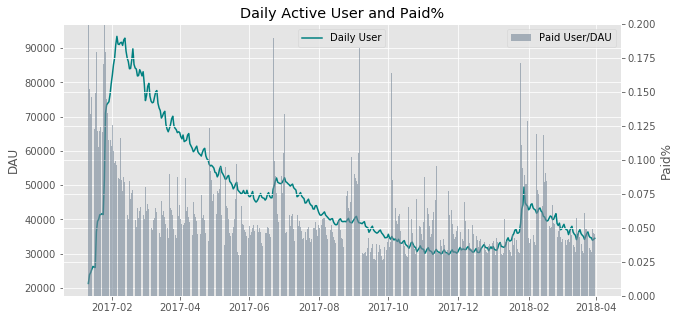

In [17]:
# 畫DAU 和巴哈人氣
plt.figure(figsize=(10,5))
plt.style.use("ggplot")
plt.title("Daily Active User and Paid%")

a = plt.plot(Daily_per["Date"], Daily_per["DAU_PKG"], label="Daily User", color="teal")
plt.ylabel("DAU")
plt.legend(loc=9)

plt.twinx()
b = plt.bar(Daily_per["Date"], Daily_per["Paid%"], label="Paid User/DAU", 
             color="lightslategray", alpha =0.6)

plt.ylim(0,0.2)
plt.ylabel("Paid%")
plt.xlabel("Date")
plt.legend(loc=1)

plt.savefig('DailyUser&Paid%.png', bbox_inches='tight')

0     0.5068
1     0.1797
2     0.0677
3     0.0546
4     0.0670
5     0.0407
6     0.0396
7     0.0358
8     0.0304
9     0.0250
10    0.0304
11    0.0313
12    0.0427
13    0.0332
14    0.0375
dtype: float64


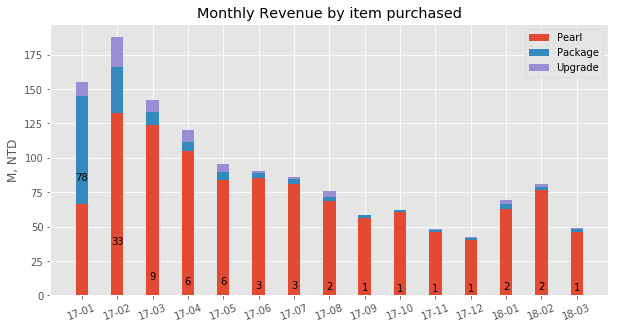

In [18]:
# 看每月營收來源比例 (珍珠 / 產包升級 / 產寶)
src = suc_records.pivot_table(index=pd.Grouper(freq="m",key="Date"),columns = "Purchase_item", values="Price", aggfunc="sum").reset_index()

N = len(src)
Package_ = src["Purchase_Package"]/1000000
Pearl_ = src["Purchase_Pearl"]/1000000
Upgrad_ = src["Upgrade_Package"]/1000000

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


plt.style.use("ggplot")
plt.figure(figsize=(10,5))
p1 = plt.bar(ind, Pearl_, width, label="Pearl")
p2 = plt.bar(ind, Package_, width,bottom=Pearl_, label="Package")
p3 = plt.bar(ind, Upgrad_, width,bottom=Pearl_+Package_, label="Upgrade")

def month_(x):
    return x.strftime("%y-%m")

plt.ylabel('M, NTD')
plt.title('Monthly Revenue by item purchased')
plt.xticks(ind,src["Date"].apply(month_),rotation=20)
plt.legend()
plt.savefig('Monthly_Purchase_item.png', bbox_inches='tight')


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % float(height),
                ha='center', va='bottom')
        
autolabel(p2)

print(round((Package_ / (Package_+Pearl_+Upgrad_ )),4))

0     0.399061
1     0.347281
2     0.309144
3     0.297564
4     0.308173
5     0.289928
6     0.288674
7     0.317277
8     0.301477
9     0.303286
10    0.311074
11    0.352159
12    0.334432
13    0.303639
14    0.360432
dtype: float64
0     0.247580
1     0.234826
2     0.229322
3     0.230077
4     0.225488
5     0.214903
6     0.229110
7     0.193217
8     0.209140
9     0.205375
10    0.204791
11    0.187574
12    0.199928
13    0.190289
14    0.186272
dtype: float64
0     0.646641
1     0.582107
2     0.538466
3     0.527641
4     0.533661
5     0.504831
6     0.517785
7     0.510493
8     0.510617
9     0.508662
10    0.515865
11    0.539733
12    0.534359
13    0.493928
14    0.546705
dtype: float64


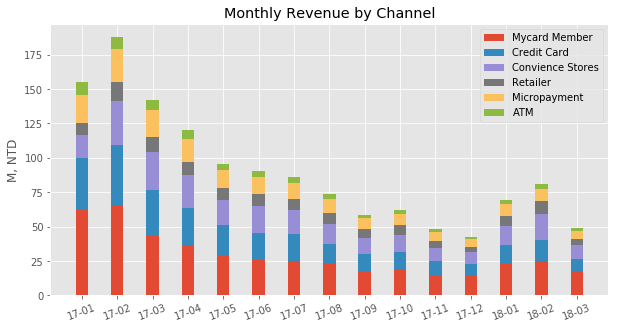

In [19]:
# 看每月營收的儲值管道分布
src = suc_records.pivot_table(index=pd.Grouper(freq="m",key="Date"),columns = "Payment_type", values="Price", aggfunc="sum").reset_index()

N = len(src)
MY_ = src["Mycard_Member"]/1000000
Cd_ = src["Credit_Card"]/1000000
cs_ = src["Convience_Stores"]/1000000
re_ = src["General_Retailer"]/1000000
Mipy_ = src["Micropayment"]/1000000
atm_ = src["ATM"]/1000000

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

print(MY_/(MY_+Cd_+cs_+re_+Mipy_+atm_))
print(Cd_/(MY_+Cd_+cs_+re_+Mipy_+atm_))
print((MY_ + Cd_)/(MY_+Cd_+cs_+re_+Mipy_+atm_))

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
p1 = plt.bar(ind, MY_, width, label= "Mycard Member")
p2 = plt.bar(ind, Cd_, width, bottom= MY_, label= "Credit Card")
p3 = plt.bar(ind, cs_, width, bottom= MY_+Cd_, label= "Convience Stores")
p4 = plt.bar(ind, re_, width, bottom= MY_+Cd_+cs_, label= "Retailer")
p5 = plt.bar(ind, Mipy_, width, bottom = MY_+Cd_+cs_+re_, label= "Micropayment")
p6 = plt.bar(ind, atm_, width, bottom = MY_+Cd_+cs_+re_+Mipy_, label= "ATM")

plt.ylabel('M, NTD')
plt.title('Monthly Revenue by Channel')
plt.xticks(ind,src["Date"].apply(month_),rotation=20)
plt.legend()

plt.savefig('Monthly_Channel.png', bbox_inches='tight')

Payment_type       Date        ATM  Convience_Stores  Credit_Card  \
0            2017-01-31  8923388.0        16611802.0   38311174.0   
1            2017-02-28  9329158.0        31759812.0   44169161.0   
2            2017-03-31  7568487.0        27794300.0   32580609.0   
3            2017-04-30  6275603.0        24113550.0   27617942.0   
4            2017-05-31  4318644.0        18024100.0   21586396.0   
5            2017-06-30  4316571.0        19079000.0   19424127.0   
6            2017-07-31  4353064.0        17273550.0   19672012.0   
7            2017-08-31  3570187.0        14483900.0   14267482.0   
8            2017-09-30  2461848.0        11943200.0   12261276.0   
9            2017-10-31  2941257.0        12541100.0   12806219.0   
10           2017-11-30  2105075.0         9843700.0    9821724.0   
11           2017-12-31  1560923.0         8358900.0    7988044.0   
12           2018-01-31  2361571.0        13858100.0   13799189.0   
13           2018-02-28  3905991.0

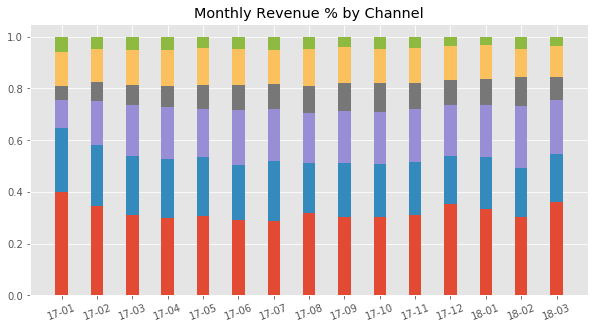

In [20]:
# 看每月營收分別來自哪個儲值管道
src["Revenue"] = src["ATM"] + src["Convience_Stores"] + src["Credit_Card"] + src["General_Retailer"] + src["Micropayment"] + src["Mycard_Member"]
src["ATM%"] = src["ATM"]/src["Revenue"]
src["Convience_Stores%"] = src["Convience_Stores"]/src["Revenue"]
src["Credit_Card%"] = src["Credit_Card"]/src["Revenue"]
src["General_Retailer%"] = src["General_Retailer"]/src["Revenue"]
src["Micropayment%"] = src["Micropayment"]/src["Revenue"]
src["Mycard_Member%"] = src["Mycard_Member"]/src["Revenue"]

N = len(src)
MY_ = src["Mycard_Member%"]
Cd_ = src["Credit_Card%"]
cs_ = src["Convience_Stores%"]
re_ = src["General_Retailer%"]
Mipy_ = src["Micropayment%"]
atm_ = src["ATM%"]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

print(src)

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
p1 = plt.bar(ind, MY_, width, label= "Mycard Member")
p2 = plt.bar(ind, Cd_, width, bottom= MY_, label= "Credit Card")
p3 = plt.bar(ind, cs_, width, bottom= MY_+Cd_, label= "Convience Stores")
p4 = plt.bar(ind, re_, width, bottom= MY_+Cd_+cs_, label= "Retailer")
p5 = plt.bar(ind, Mipy_, width, bottom = MY_+Cd_+cs_+re_, label= "Micropayment")
p6 = plt.bar(ind, atm_, width, bottom = MY_+Cd_+cs_+re_+Mipy_, label= "ATM")

plt.title('Monthly Revenue % by Channel')
plt.xticks(ind,src["Date"].apply(month_),rotation=20)
plt.savefig('Monthly_Channel%.png', bbox_inches='tight')

PART3: Customer behavior

        Amount  User%   Amount%  Cum_Amount%
0  595082800.0    0.1  0.645552     0.645552
1  153472575.0    0.2  0.166489     0.812041
2   73599800.0    0.3  0.079842     0.891883
3   40492149.0    0.4  0.043926     0.935809
4   26258400.0    0.5  0.028485     0.964295
5   14785027.0    0.6  0.016039     0.980334
6    6025505.0    0.7  0.006537     0.986870
7    4264039.0    0.8  0.004626     0.991496
8    4263740.0    0.9  0.004625     0.996121
9    3575496.0    1.0  0.003879     1.000000


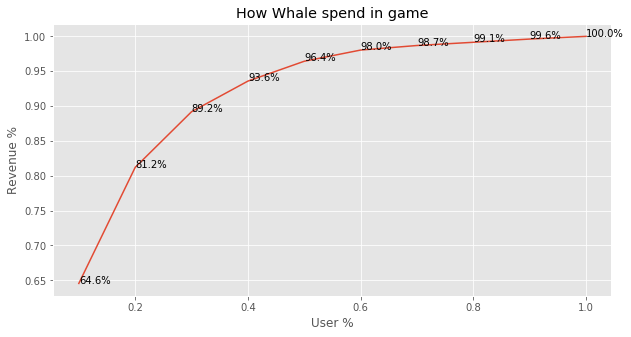

In [22]:
# 確認前10 20 30 40 50 ... 100 的玩家貢獻營收的比例
# step1. 平分一個範圍  
num_list = list(np.linspace(0,1,11))
num_list.pop(0)

# step2. 透過 np.array_split 把一個 df 切成十等分
cum_list = []
for i in range(10):
    cum_list.append(np.array_split(user,10)[i].Total_amount.sum())

# step3. 計算出玩家數量比例和消費金額比例
src = pd.DataFrame({"Amount": cum_list,"User%": num_list})
src["Amount%"] = src["Amount"]/src["Amount"].sum()
src["Cum_Amount%"] = src["Amount%"].cumsum()

print(src)

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(src["User%"], src["Cum_Amount%"])
plt.xlabel("User %")
plt.ylabel("Revenue %")

# 標註線上的值, 並將數值轉百分比
for a,b in zip(src["User%"],src["Cum_Amount%"]): 
    plt.text(a, b, "{:.1%}".format(round(b,3)))

plt.title("How Whale spend in game")
plt.savefig('User&spending_dist.png', bbox_inches='tight')

   hour        Price  Revenue%
0    00   66048999.0  0.048451
1    01   43128689.0  0.031638
2    02   29112079.0  0.021356
3    03   17242372.0  0.012648
4    04   12135832.0  0.008902
5    05    8937812.0  0.006556
6    06   10548176.0  0.007738
7    07   19591277.0  0.014372
8    08   27879039.0  0.020451
9    09   39817325.0  0.029209
10   10   47362833.0  0.034744
11   11   52107720.0  0.038225
12   12   59247163.0  0.043462
13   13   66665596.0  0.048904
14   14   66871117.0  0.049055
15   15   67889484.0  0.049802
16   16   70359500.0  0.051614
17   17   79412946.0  0.058255
18   18   91194946.0  0.066898
19   19  104859677.0  0.076922
20   20  105434960.0  0.077344
21   21  101355606.0  0.074351
22   22   94217411.0  0.069115
23   23   81778904.0  0.059990


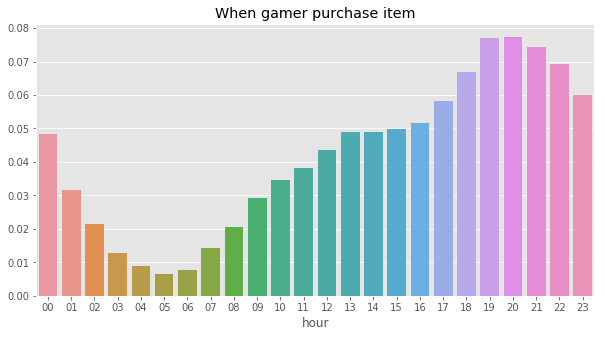

In [23]:
# 確認不同小時的營收狀況
src = suc_records.groupby("hour").Price.sum().reset_index()
src["Revenue%"] = src["Price"]/src["Price"].sum()
print(src)

plt.figure(figsize=(10,5))
sns.barplot(x="hour", y="Revenue%", data = src)
plt.ylabel('')
plt.title('When gamer purchase item')
plt.savefig('hourly_payment.png', bbox_inches='tight')

  weekday        Price  Revenue%
1     Mon  161086642.0  0.118168
5     Tue  156783718.0  0.115012
6     Wed  192922124.0  0.141522
4     Thu  244723859.0  0.179522
0     Fri  198821949.0  0.145849
2     Sat  210037121.0  0.154077
3     Sun  198824050.0  0.145851


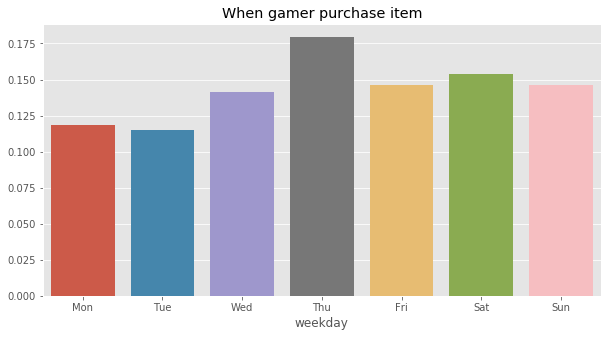

In [24]:
# 確認不同天的營收狀況
# 重新排序星期順序
src = suc_records.groupby("weekday").Price.sum().reset_index()
src["Revenue%"] = src["Price"]/src["Price"].sum()

day_ = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
src['weekday'] = pd.Categorical(src['weekday'],day_)
src= src.sort_values("weekday")

print(src)

plt.figure(figsize=(10,5))
sns.barplot(x="weekday", y="Revenue%", data = src)
plt.ylabel('')
plt.title('When gamer purchase item')
plt.savefig('Weekday_payment.png', bbox_inches='tight')

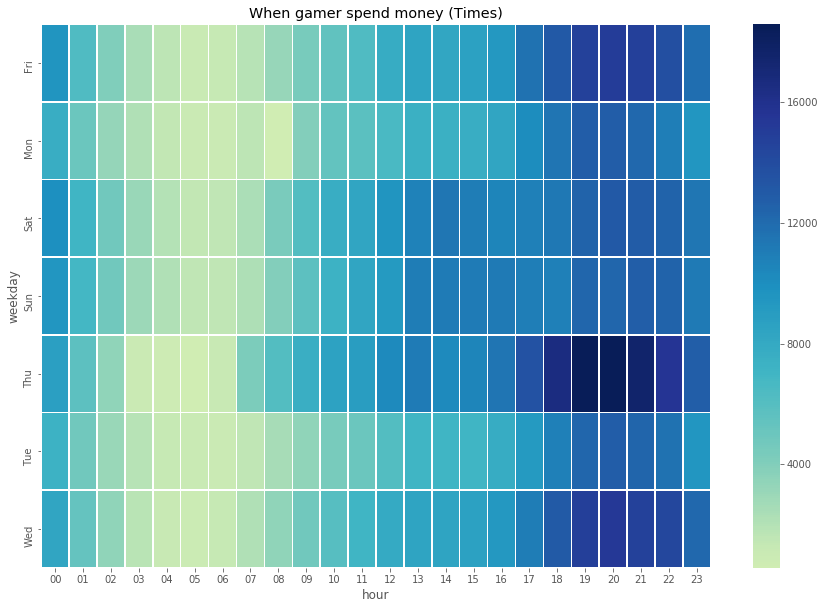

In [25]:
# 看星期和小時的付費次數狀況
src = suc_records.pivot_table(columns="hour", index="weekday", values="Price", aggfunc="count")

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(src, annot=False, linewidths=.5, ax=ax ,center=7000, cmap="YlGnBu")

plt.title('When gamer spend money (Times)')
plt.savefig('Payhabbit_heatmap.png', bbox_inches='tight')

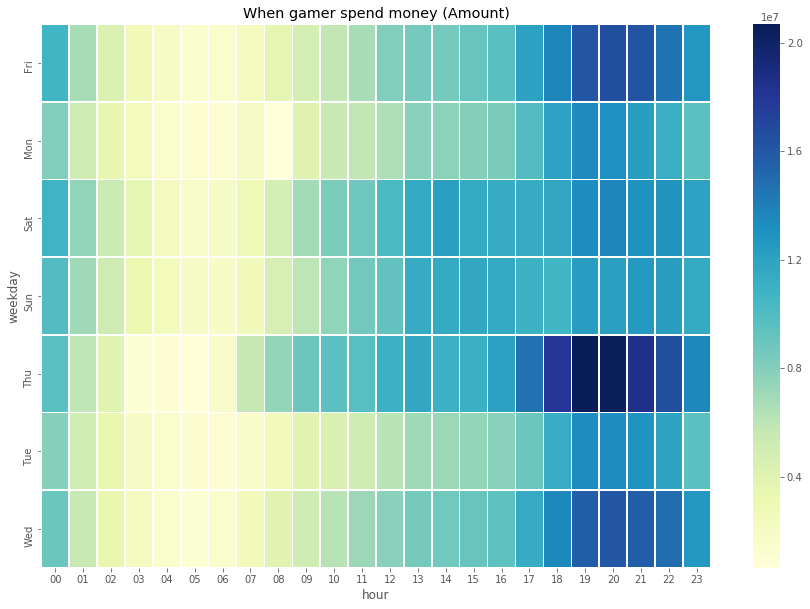

In [26]:
# 看星期和小時的付費金額狀況
src = suc_records.pivot_table(columns="hour", index="weekday", values="Price", aggfunc="sum")

f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(src, annot=False, linewidths=.5, ax=ax , cmap="YlGnBu")

plt.title('When gamer spend money (Amount)')
plt.savefig('PayAmount_heatmap.png', bbox_inches='tight')

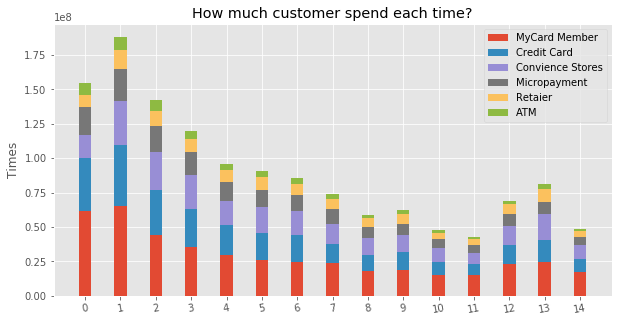

In [21]:
# 把每個面額在不同管道的消費次數加起
src["total_times"] = src.sum(axis=1)


N = len(src)
atm_ = src["ATM"]
cs_ = src["Convience_Stores"]
cd_ = src["Credit_Card"]
re_ = src["General_Retailer"]
mipy_ = src["Micropayment"]
mm_ = src["Mycard_Member"]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
p1 = plt.bar(ind, mm_, width, label="MyCard Member")
p2 = plt.bar(ind, cd_, width,bottom=mm_, label="Credit Card")
p3 = plt.bar(ind, cs_, width,bottom=mm_+cd_, label="Convience Stores")
p4 = plt.bar(ind, mipy_, width,bottom=mm_+cd_+cs_, label="Micropayment")
p5 = plt.bar(ind, re_, width,bottom=mm_+cd_+cs_+mipy_, label="Retaier")
p5 = plt.bar(ind, atm_, width,bottom=mm_+cd_+cs_+mipy_+re_, label="ATM")

plt.xticks(ind,src.index,rotation=10)

plt.legend()
plt.ylabel('Times')
plt.title('How much customer spend each time?')
plt.savefig('DenominationByChannel.png', bbox_inches='tight')

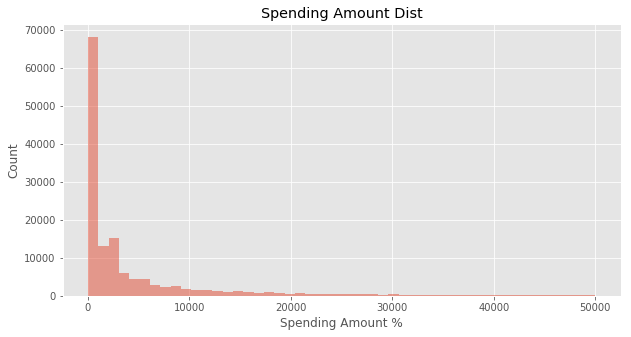

In [27]:
# 看每個玩家附款金額的間距分布
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
bins = np.linspace(0, 50000, 50)
plt.hist(user["Total_amount"].tolist() , bins,alpha = 0.5)
plt.xlabel("Spending Amount %")
plt.ylabel("Count")
plt.title("Spending Amount Dist")

plt.savefig('Spending Amount Dist.png', bbox_inches='tight')
    

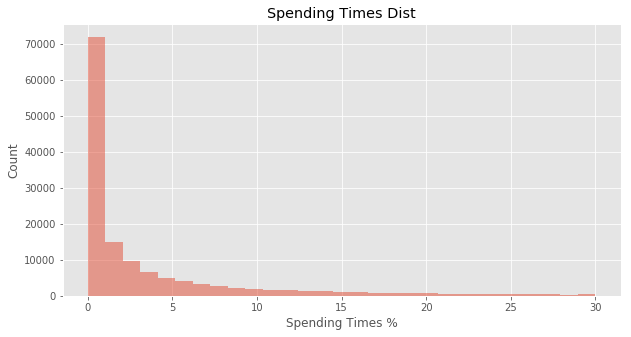

In [28]:
# 看每個玩家附款次數的間距分布
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
bins = np.linspace(0, 30,30 )
plt.hist(user["Total_count"].tolist() , bins,alpha = 0.5)
plt.xlabel("Spending Times %")
plt.ylabel("Count")
plt.title("Spending Times Dist")

plt.savefig('Spending Times Dist.png', bbox_inches='tight')


   Prefer_payment  User_ID   User%
0             ATM     5576  0.0391
1              CS    31479  0.2207
2     Credit_card    51640  0.3621
3           Micro    35616  0.2497
4  multi_payments    10505  0.0737
5        retailer     7792  0.0546


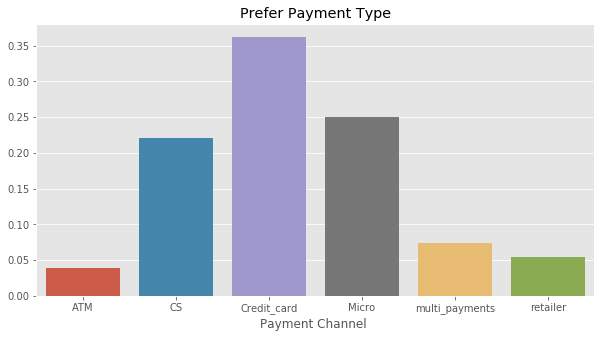

In [29]:
# 確認玩家傾向的支付管道分布狀況
src = user.groupby("Prefer_payment").User_ID.count().reset_index()
src["User%"] = round(src["User_ID"]/src["User_ID"].sum(),4)
print(src)

plt.figure(figsize=(10,5))
sns.barplot(x="Prefer_payment", y="User%", data = src)
plt.title("Prefer Payment Type")
plt.ylabel("")
plt.xlabel("Payment Channel ")

plt.savefig('Prefer Payment Type.png', bbox_inches='tight')

Payment_type     ATM  Convience_Stores  Credit_Card  General_Retailer  \
Price                                                                   
150.0         1103.0           21246.0      11478.0            9902.0   
300.0         2613.0           76505.0      25610.0           13750.0   
500.0         3397.0           48901.0      22271.0           12007.0   
1000.0        6873.0           84268.0      43697.0           21537.0   
2000.0        2330.0           10547.0      11774.0            4094.0   
3000.0        9142.0           28184.0      43424.0           20405.0   
5000.0         918.0            2050.0       4649.0            3107.0   
10000.0       1109.0               0.0          0.0               0.0   

Payment_type  Micropayment  Mycard_Member  total_times  
Price                                                   
150.0              15163.0        37541.0      96433.0  
300.0              27702.0       115896.0     262076.0  
500.0              24697.0        43055.0

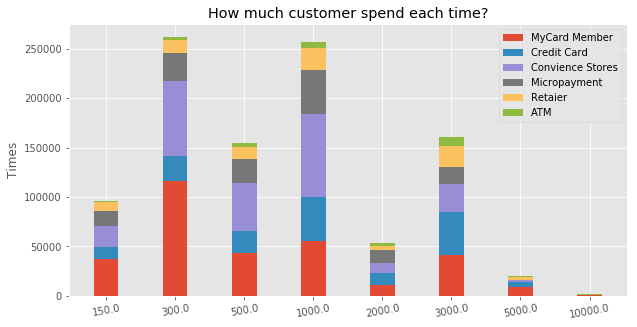

In [33]:
# 看每個儲值管道買珍珠的面額概況
temp = suc_records[suc_records["Purchase_item"] =="Purchase_Pearl"]
src = temp.pivot_table(index="Price", columns="Payment_type", values="User_ID", aggfunc="count").fillna(0)

# 把每個面額在不同管道的消費次數加起
src["total_times"] = src.sum(axis=1)
print(src)

N = len(src)
atm_ = src["ATM"]
cs_ = src["Convience_Stores"]
cd_ = src["Credit_Card"]
re_ = src["General_Retailer"]
mipy_ = src["Micropayment"]
mm_ = src["Mycard_Member"]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
p1 = plt.bar(ind, mm_, width, label="MyCard Member")
p2 = plt.bar(ind, cd_, width,bottom=mm_, label="Credit Card")
p3 = plt.bar(ind, cs_, width,bottom=mm_+cd_, label="Convience Stores")
p4 = plt.bar(ind, mipy_, width,bottom=mm_+cd_+cs_, label="Micropayment")
p5 = plt.bar(ind, re_, width,bottom=mm_+cd_+cs_+mipy_, label="Retaier")
p5 = plt.bar(ind, atm_, width,bottom=mm_+cd_+cs_+mipy_+re_, label="ATM")

plt.xticks(ind,src.index,rotation=10)

plt.legend()
plt.ylabel('Times')
plt.title('How much customer spend each time?')
plt.savefig('DenominationByChannel.png', bbox_inches='tight')

   First_date  Paying_days  Playing_days         dif      dif%
0  2017-01-31   164.579984    434.367622  269.787638  0.621104
1  2017-02-28   141.345237    412.936997  271.591760  0.657707
2  2017-03-31   131.568682    381.715194  250.146512  0.655322
3  2017-04-30   117.313176    350.013647  232.700471  0.664833
4  2017-05-31   102.179722    321.041383  218.861661  0.681724
5  2017-06-30    93.969697    286.173714  192.204017  0.671634
6  2017-07-31    84.102616    260.842656  176.740040  0.677573
7  2017-08-31    75.367797    225.997175  150.629379  0.666510
8  2017-09-30    59.041105    199.430593  140.389488  0.703952
9  2017-10-31    56.269303    167.770245  111.500942  0.664605
10 2017-11-30    49.551190    136.688095   87.136905  0.637487
11 2017-12-31    38.613948    105.293898   66.679950  0.633275
12 2018-01-31    20.188918     68.408971   48.220053  0.704879
13 2018-02-28    12.001626     45.027642   33.026016  0.733461
14 2018-03-31     3.703422     16.418251   12.714829  0

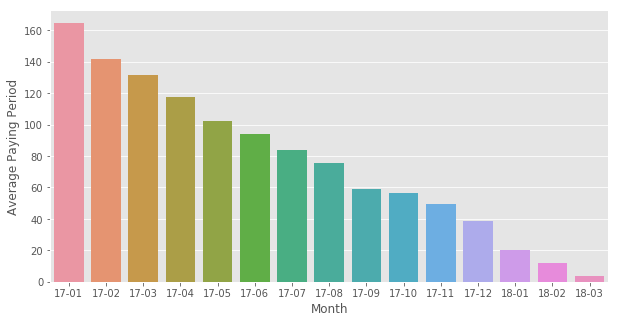

In [34]:
# 看不同加入時間的 平均付款的天數為

src = paid_user.groupby(pd.Grouper(freq="m",key="First_date")).agg({"Paying_days":"mean","Playing_days":"mean"}).reset_index()
src["dif"] = src["Playing_days"] - src["Paying_days"]
src["dif%"] = src["dif"] / src["Playing_days"]
print(src)


plt.figure(figsize=(10,5))
src["First_date"] = src["First_date"].apply(month_)
sns.barplot(x="First_date", y="Paying_days", data = src).set(xlabel="Month", ylabel="Average Paying Period")
plt.savefig('AveragePayingPeriod_Joining Month.png', bbox_inches='tight')


PART4: BEHAVIOR BY PKG

Pack_type
Essential_P    16218
Luxurious_P    15738
Starter_P      72263
Name: User_ID, dtype: int64


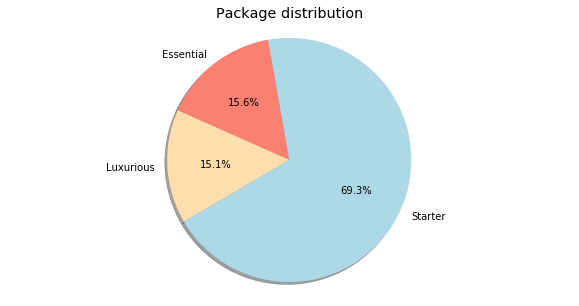

In [35]:
# 看玩家購買產包的分布狀況
src = user.groupby("Pack_type").User_ID.count()
src = src.drop(["NA"])
print(src)

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.title('Package distribution')

label_ = ["Essential", "Luxurious", "Starter"]
color_ = ['salmon', 'navajowhite', 'lightblue']
plt.pie(src , labels=label_, autopct='%1.1f%%', colors=color_, shadow= True, startangle=100)
plt.axis('equal')

plt.savefig('PKG_pie.png', bbox_inches='tight')


In [38]:
# 看不同產包的付費比例
src = user.pivot_table(index="Pack_type", columns="User_type", values="User_ID", aggfunc="count")
src = src.drop(["NA"])
src["PKG_Paid%"] = src["Paid_user"]/(src["NonPaid_user"] + src["Paid_user"])
src

User_type,NonPaid_user,Paid_user,PKG_Paid%
Pack_type,,,
Essential_P,8063.0,8155.0,0.502836
Luxurious_P,6846.0,8892.0,0.565002
Starter_P,48888.0,23375.0,0.323471


Pack_type First_date  Essential_P  Luxurious_P    NA  Starter_P  Total_PKG  \
0         2017-01-31         8765         8400  9977      27179      44344   
1         2017-02-28         3692         2340  8965      23337      29369   
2         2017-03-31          962          607  4006       6149       7718   
3         2017-04-30          555          792  2546       3487       4834   
4         2017-05-31          465         1281  2092       1947       3693   
5         2017-06-30          347          298  1732       2505       3150   
6         2017-07-31          294          234  1601       1913       2441   
7         2017-08-31          203          507  1116       1161       1871   
8         2017-09-30          123          125  1105        644        892   
9         2017-10-31           84          119   711        576        779   
10        2017-11-30           89           71   582        512        672   
11        2017-12-31           77           53   571        527 

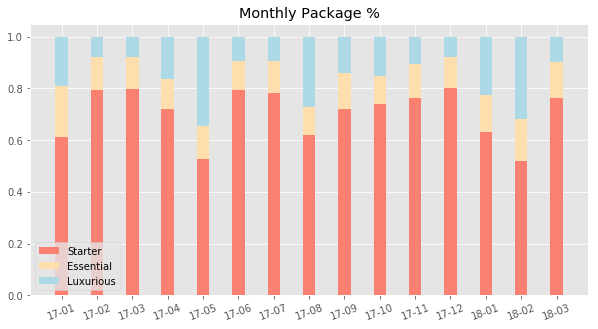

In [36]:
# 看玩家每月購買產包的分布狀況
src = user.pivot_table(index= pd.Grouper(freq='m',key="First_date"), columns= "Pack_type", values="User_ID", aggfunc="count").reset_index()
src["Total_PKG"] = src["Essential_P"] + src["Luxurious_P"] + src["Starter_P"]

list_ = ["Essential_P","Luxurious_P","Starter_P" ]
for i in list_:
    str_ = i +"%"
    src[str_] = src[i]/src["Total_PKG"]

print(src)

N = len(src)
Es_ = src["Essential_P%"]
Lu_ = src["Luxurious_P%"]
St_ = src["Starter_P%"]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.style.use("ggplot")
plt.figure(figsize=(10,5))

p1 = plt.bar(ind, St_, width, label= "Starter", color="salmon")
p2 = plt.bar(ind, Es_, width, bottom= St_, label= "Essential", color="navajowhite")
p3 = plt.bar(ind, Lu_, width, bottom= St_+Es_, label= "Luxurious", color="lightblue")

plt.title('Monthly Package %')

def month_(x):
    return x.strftime("%y-%m")
plt.xticks(ind,src["First_date"].apply(month_),rotation=20)
plt.legend()

plt.savefig('Monthly_PKG%.png', bbox_inches='tight')


Prefer_payment   ATM    CS  Credit_card  Micro  multi_payments  retailer  \
Pack_type                                                                  
Essential_P      691  1931         7079   4979            1372       166   
Luxurious_P     1311   643         8102   3419            1772       491   
Starter_P       2796  9704        31385  23875            3980       523   

Prefer_payment  TotalUser      ATM%       CS%  Credit_card%    Micro%  \
Pack_type                                                               
Essential_P         16218  0.042607  0.119065      0.436490  0.307005   
Luxurious_P         15738  0.083302  0.040857      0.514805  0.217245   
Starter_P           72263  0.038692  0.134287      0.434316  0.330390   

Prefer_payment  multi_payments%  retailer%  
Pack_type                                   
Essential_P            0.084597   0.010236  
Luxurious_P            0.112594   0.031198  
Starter_P              0.055077   0.007237  


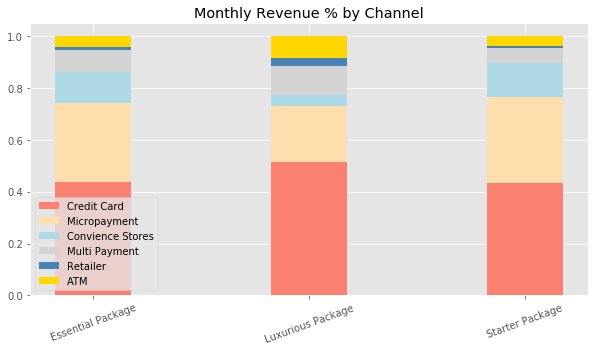

In [37]:
# 看不同產包購買者 習慣的支付管道為河
src = user.pivot_table(columns="Prefer_payment", index = "Pack_type", values="User_ID", aggfunc="count")
src["TotalUser"] = src["ATM"] + src["CS"] + src["Credit_card"] + src["Micro"] + src["multi_payments"] + src["retailer"]

for i in src.columns[:6]:
    str_ = i + "%"
    src[str_] = src[i]/src["TotalUser"]

# 把 NA 資料拿掉
src = src.drop(["NA"])
print(src)

N = len(src)
Cd_ = src["Credit_card%"]
cs_ = src["CS%"]
re_ = src["retailer%"]
Mipy_ = src["Micro%"]
atm_ = src["ATM%"]
multi_ = src["multi_payments%"]

ind = np.arange(len(src))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.style.use("ggplot")
plt.figure(figsize=(10,5))

p1 = plt.bar(ind, Cd_, width, label= "Credit Card",color="salmon")
p2 = plt.bar(ind, Mipy_, width, bottom= Cd_, label= "Micropayment", color="navajowhite")
p3 = plt.bar(ind, cs_, width, bottom= Cd_+Mipy_, label= "Convience Stores", color="lightblue")
p4 = plt.bar(ind, multi_, width, bottom = Cd_+Mipy_+cs_, label= "Multi Payment", color="lightgray")
p5 = plt.bar(ind, re_, width, bottom = Cd_+Mipy_+cs_+multi_, label= "Retailer", color="steelblue")
p6 = plt.bar(ind, atm_, width, bottom = Cd_+Mipy_+cs_+multi_+re_, label= "ATM", color="gold")

label_ = ["Essential Package","Luxurious Package","Starter Package"]
plt.title('Monthly Revenue % by Channel')
plt.xticks(ind, label_, rotation=20)
plt.legend()
plt.savefig('Channel_by_Package.png', bbox_inches='tight')

Text(0.5,1,'Spending')

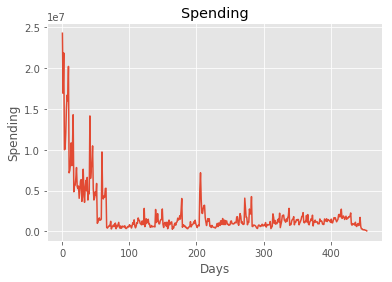

In [30]:
# 用上次付費時間來看, 玩家的總付費金額
src = user.groupby("Stopping_days").Total_amount.sum().reset_index()

plt.figure(figsize=(10,5))
plt.style.use("ggplot")
plt.figure()
plt.plot(src["Stopping_days"], src["Total_amount"])
plt.xlabel("Days")
plt.ylabel("Spending")
plt.title("Spending")

Text(0.5,1,'Spending')

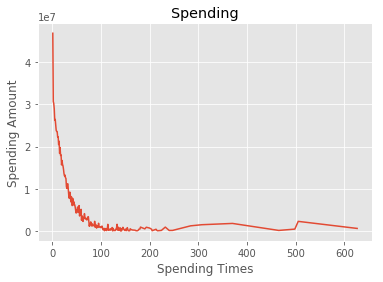

In [31]:
# 用總付費次數來看, 玩家的總付費金額
src = user.groupby("Total_count").Total_amount.sum().reset_index()

plt.figure(figsize=(10,5))
plt.style.use("ggplot")
plt.figure()
plt.plot(src["Total_count"], src["Total_amount"])
plt.xlabel("Spending Times")
plt.ylabel("Spending Amount")
plt.title("Spending")

In [ ]:
# 確認哪種付費管道的離開率較高 (平均上次付款時間較久)
src = user.groupby("Prefer_payment").agg({"User_ID":"count","Stopping_days":"mean" ,"Playing_days":"mean"}).reset_index()
src.sort_values(by="User_ID",ascending=False)


In [ ]:
# 確認不同停止付費的天數下的玩家總數
src = user.groupby("Stopping_days").agg({"User_ID":"count"}).reset_index()


plt.style.use("ggplot")
plt.figure()
plt.plot(src["Stopping_days"], src["User_ID"])
plt.xlabel("Stopping days")
plt.ylabel("Count")
plt.title("Stopping dist")

In [ ]:
## 確認沒有購買產包日的比數
print(user2.Join_Date.isnull().values.sum())
print(len(user2) - len(new_user))

統計分析

In [41]:
# One Way ANOVA
# 確認 不同時間點加入的付費期間
print(paid_user.groupby(pd.Grouper(freq="m",key="First_date")).Paying_days.mean())
print("\n")

src = paid_user.pivot_table(index=pd.Grouper(freq="m",key="First_date"), columns="Pack_type", values="Paying_days", aggfunc="mean")
src = src.drop(columns ="NA")
print(src)


# one way anova
print("\n")
print("Anova result: statistic / p-value")
stats.f_oneway(src["Essential_P"],src["Luxurious_P"],src["Starter_P"])
# -> 結果顯示不同pack 的平均付費時間並無明顯差異

First_date
2017-01-31    164.579984
2017-02-28    141.345237
2017-03-31    131.568682
2017-04-30    117.313176
2017-05-31    102.179722
2017-06-30     93.969697
2017-07-31     84.102616
2017-08-31     75.367797
2017-09-30     59.041105
2017-10-31     56.269303
2017-11-30     49.551190
2017-12-31     38.613948
2018-01-31     20.188918
2018-02-28     12.001626
2018-03-31      3.703422
Freq: M, Name: Paying_days, dtype: float64


Pack_type   Essential_P  Luxurious_P   Starter_P
First_date                                      
2017-01-31   148.452450   181.388071  148.263719
2017-02-28   135.652987   150.313740  143.845072
2017-03-31   129.273381   146.318885  129.275235
2017-04-30   119.972868   127.302053  106.903167
2017-05-31   110.182266   118.112016   97.638191
2017-06-30   100.044693   102.034682   98.839523
2017-07-31    85.920530   109.435115   96.257475
2017-08-31    89.767442    85.139738   79.970501
2017-09-30    76.541667    90.050000   69.088106
2017-10-31    66.354167    72.

F_onewayResult(statistic=0.33756091853473624, pvalue=0.7154263550561595)

In [49]:
# 確認 不同時間點加入的離開時間
print(paid_user.groupby(pd.Grouper(freq="m",key="First_date")).Stopping_days.mean())
print("\n")

src = paid_user.pivot_table(index=pd.Grouper(freq="m",key="First_date"), columns="Pack_type", values="Stopping_days", aggfunc="mean")
src = src.drop(columns ="NA")
print(src)


# one way anova
print("\n")
print("Anova result: statistic / p-value")
stats.f_oneway(src["Essential_P"],src["Luxurious_P"],src["Starter_P"])
# -> 結果顯示不同pack 的平均離開時間並無明顯差異

First_date
2017-01-31    269.787638
2017-02-28    271.591760
2017-03-31    250.146512
2017-04-30    232.700471
2017-05-31    218.861661
2017-06-30    192.204017
2017-07-31    176.740040
2017-08-31    150.629379
2017-09-30    140.389488
2017-10-31    111.500942
2017-11-30     87.136905
2017-12-31     66.679950
2018-01-31     48.220053
2018-02-28     33.026016
2018-03-31     12.714829
Freq: M, Name: Stopping_days, dtype: float64


Pack_type   Essential_P  Luxurious_P   Starter_P
First_date                                      
2017-01-31   286.931271   260.088702  282.591986
2017-02-28   278.473144   263.100000  270.029580
2017-03-31   253.369305   235.476780  252.847418
2017-04-30   228.794574   218.029326  243.789140
2017-05-31   209.931034   206.896130  220.517588
2017-06-30   188.703911   186.843931  187.018568
2017-07-31   174.099338   150.129771  165.411960
2017-08-31   136.325581   136.960699  150.153392
2017-09-30   120.902778   106.825000  128.436123
2017-10-31    98.958333    9

F_onewayResult(statistic=0.08148337346971468, pvalue=0.9218933847046616)

In [43]:
# 確認 不同支付習慣 在 不同時間點加入的付費期間
src = paid_user.pivot_table(index=pd.Grouper(freq="m",key="First_date"), columns="Prefer_payment", values="Pearl_count", aggfunc="sum")
print(src)


# one way anova
print("\n")
print("Anova result: statistic / p-value")
stats.f_oneway(src["ATM"],src["CS"],src["Credit_card"],src["Micro"],src["multi_payments"],src["retailer"])
# -> 結果顯示不同pack 的平均付費時間並無明顯差異

Prefer_payment    ATM     CS  Credit_card  Micro  multi_payments  retailer
First_date                                                                
2017-01-31      13115  90473        81289  69695           70173     24416
2017-02-28       4160  62168        32174  27182           26401     13694
2017-03-31       1038  23189         8944   9882            7940      6151
2017-04-30        571  12964         5864   5431            5458      3606
2017-05-31        402   9061         4633   2884            3372      2858
2017-06-30        512   8512         3587   2956            2676      2303
2017-07-31        276   6877         3073   2430            2387      1737
2017-08-31        187   4543         2124   1393            1294      1415
2017-09-30        172   3696         1473    945             880       992
2017-10-31         72   2330         1065    671             775       752
2017-11-30         40   2054          840    450             576       618
2017-12-31         85   1

F_onewayResult(statistic=1.1748293466672035, pvalue=0.32842502792877637)

其他資訊

In [ ]:
# 根據使用者加入的時間和儲值的時間分布
output = pd.pivot_table(df6, values="User_ID" , columns = "Paid_Game_Days", index= "Game_Days" , aggfunc= "count" ,fill_value = 0).sort_index(axis = "index" , ascending= False)

# 輸出資料
output.to_csv("out.csv" , sep=",")

In [ ]:
## 將玩家加入時間填入交易紀錄來計算 該次付費時的遊戲天數
df6 = pd.merge(user_temp,user2[["User_ID","First_Date"]], left_on="User_ID", right_on = "User_ID" , how = "left")
df6["Game_Days"] = dt.datetime(2018,2,28) -  df6["First_Date"]
df6["Paid_Game_Days"] = df6["Date"] - df6["First_Date"]

In [ ]:
# 確認購買產包的玩家數目有多少
print(user.Pack_type.value_counts().Starter_P+user.Pack_type.value_counts().Essential_P + user.Pack_type.value_counts().Luxurious_P)

# 確認購買珍珠的玩家數目有多少
print(user.Pack_type.value_counts())